# reading files and getting ave sampling rate

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

''' csv file keys: 
'time', 'seconds_elapsed', 'rotationRateX', 'rotationRateY',
'rotationRateZ', 'gravityX', 'gravityY', 'gravityZ', 'accelerationX',
'accelerationY', 'accelerationZ', 'quaternionW', 'quaternionX',
'quaternionY', 'quaternionZ', 'pitch', 'roll', 'yaw'

Sensor logger sampling rate is 100 Hz
'''

# Reading in file
path_to_file = "/Volumes/disko!/HomeStretch/001_BicepCurl_R_T.csv" # update this to the path of your file
path_to_file = "/Volumes/disko!/HomeStretch/002_BicepCurl_R_A.csv"

df = pd.read_csv(path_to_file)

# getting sampling rate from the data
time = df['seconds_elapsed'].values
dt = np.diff(time)
sampling_rate = 1 / np.mean(dt)
print(f"Estimated Sampling Rate: {sampling_rate:.2f} Hz")

Estimated Sampling Rate: 99.69 Hz


# plotting inital plots

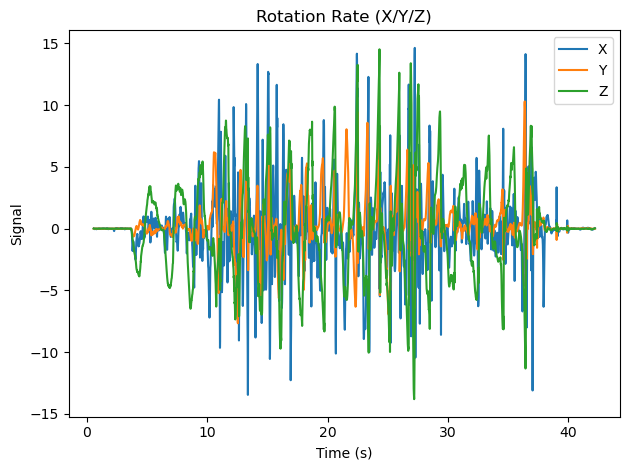

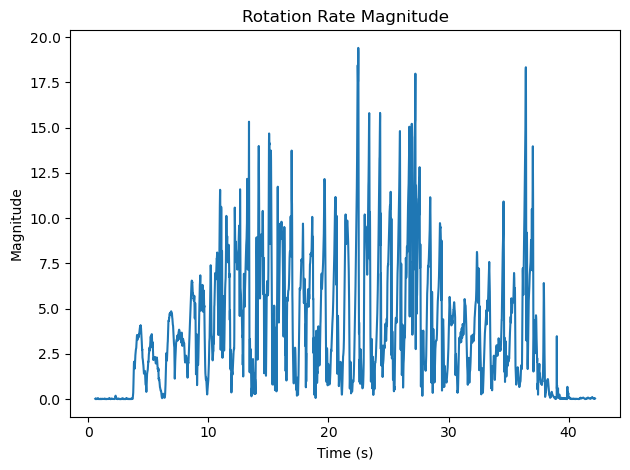

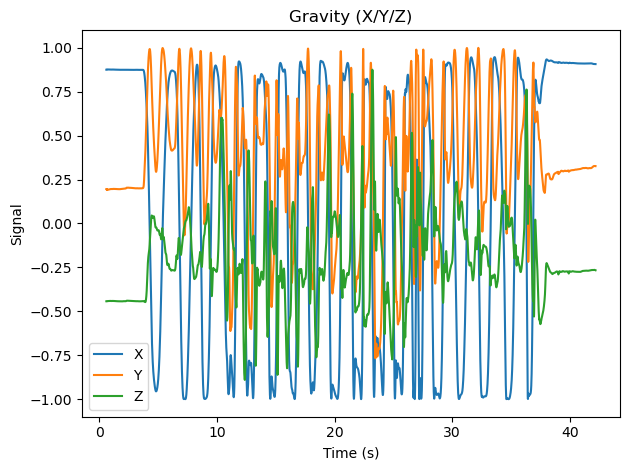

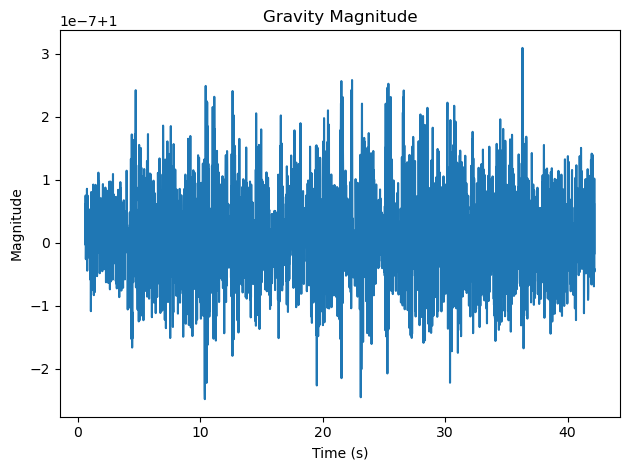

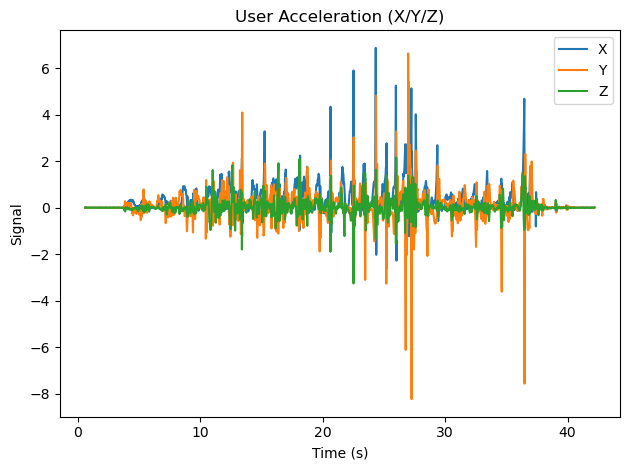

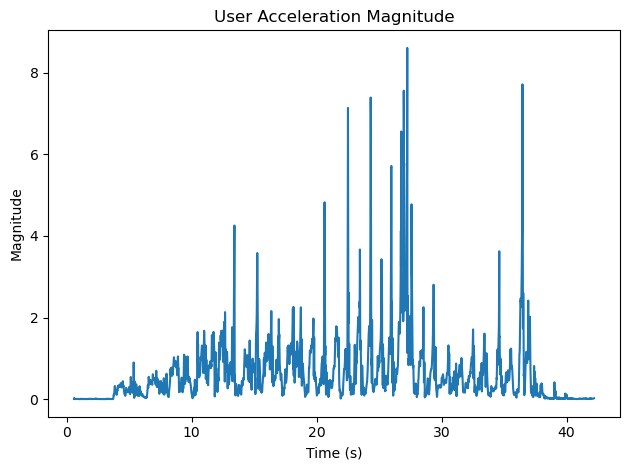

In [102]:
# ---- Helper: plot 3-axis + magnitude ----
def plot_3axis_and_mag(df, t_col, x_col, y_col, z_col, title_prefix):
    t = df[t_col].values
    x = df[x_col].values
    y = df[y_col].values
    z = df[z_col].values
    mag = np.sqrt(x**2 + y**2 + z**2)

    # 3-axis plot
    plt.figure()
    plt.plot(t, x, label='X')
    plt.plot(t, y, label='Y')
    plt.plot(t, z, label='Z')
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.title(f"{title_prefix} (X/Y/Z)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # magnitude plot
    plt.figure()
    plt.plot(t, mag)
    plt.xlabel("Time (s)")
    plt.ylabel("Magnitude")
    plt.title(f"{title_prefix} Magnitude")
    plt.tight_layout()
    plt.show()

# ---- Plot rotation rate ----
plot_3axis_and_mag(
    df, 'seconds_elapsed',
    'rotationRateX', 'rotationRateY', 'rotationRateZ',
    "Rotation Rate"
)

# ---- Plot gravity ----
plot_3axis_and_mag(
    df, 'seconds_elapsed',
    'gravityX', 'gravityY', 'gravityZ',
    "Gravity"
)

# ---- Plot acceleration ----
plot_3axis_and_mag(
    df, 'seconds_elapsed',
    'accelerationX', 'accelerationY', 'accelerationZ',
    "User Acceleration"
)


# manually segment start and end of excersize

Segment shape: (3190, 18)
Segment time range: 3.006744146347046 to 34.995063066482544


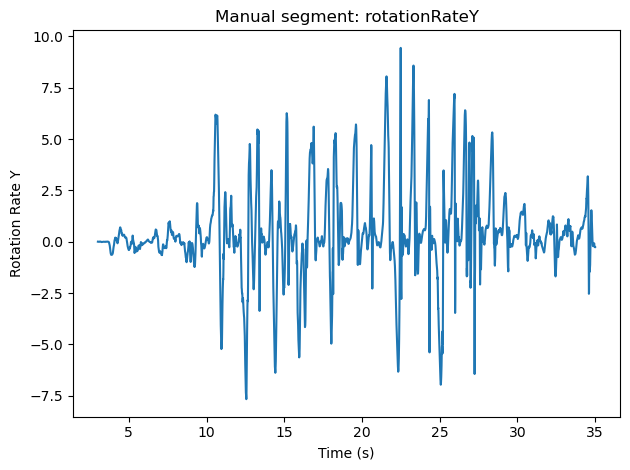

In [103]:
# 1) Choose manual boundaries (edit these)
start_time = 3.0
end_time   = 35.0

# start_time = 0.0
# end_time   = 41.0

# 2) Slice
df_seg = df[(df['seconds_elapsed'] >= start_time) &
            (df['seconds_elapsed'] <= end_time)].copy()

print("Segment shape:", df_seg.shape)
print("Segment time range:",
      df_seg['seconds_elapsed'].iloc[0], "to", df_seg['seconds_elapsed'].iloc[-1])

# 3) Replot to confirm (pick the clean axis you liked)
t_seg = df_seg['seconds_elapsed'].values
sig_seg = df_seg['rotationRateY'].values

plt.figure()
plt.plot(t_seg, sig_seg)
plt.title("Manual segment: rotationRateY")
plt.xlabel("Time (s)")
plt.ylabel("Rotation Rate Y")
plt.tight_layout()
plt.show()

df = df_seg # update df to be the segmented version for the rest of the analysis


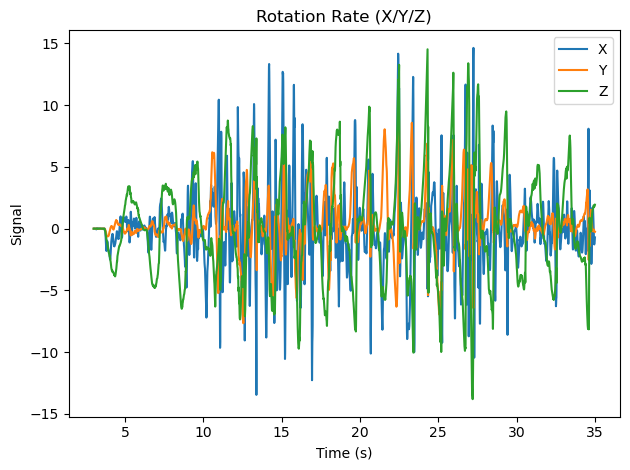

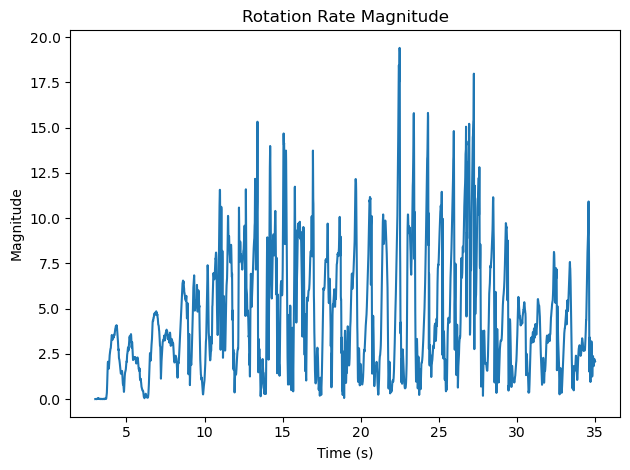

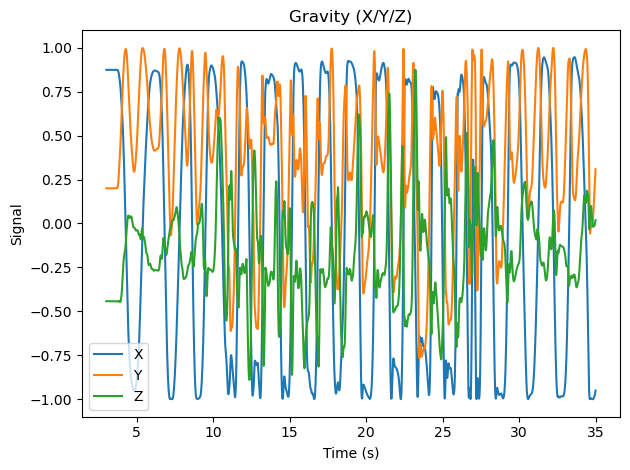

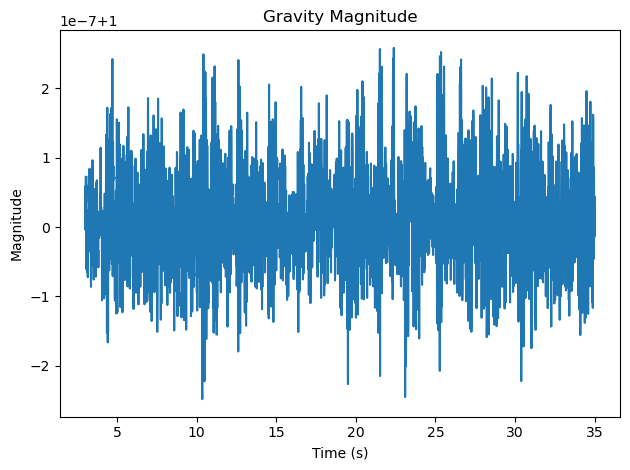

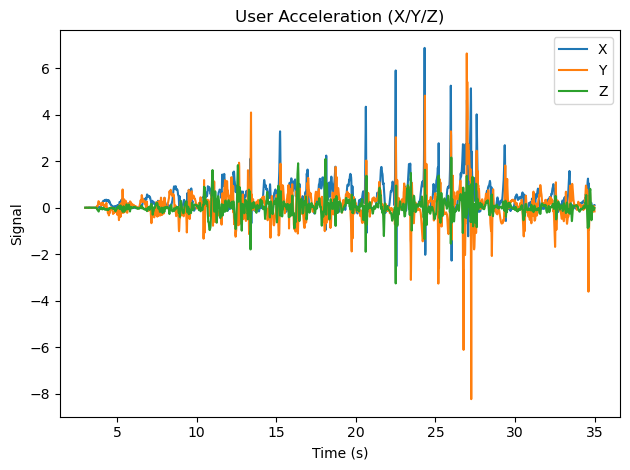

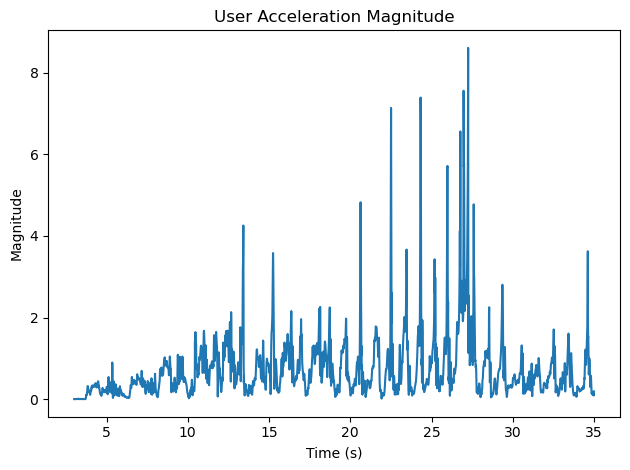

In [104]:
plot_3axis_and_mag(
    df, 'seconds_elapsed',
    'rotationRateX', 'rotationRateY', 'rotationRateZ',
    "Rotation Rate"
)

# ---- Plot gravity ----
plot_3axis_and_mag(
    df, 'seconds_elapsed',
    'gravityX', 'gravityY', 'gravityZ',
    "Gravity"
)

# ---- Plot acceleration ----
plot_3axis_and_mag(
    df, 'seconds_elapsed',
    'accelerationX', 'accelerationY', 'accelerationZ',
    "User Acceleration"
)

# Preprocessing 

## Bias Removal & Low-Pass

In [123]:
from scipy.signal import butter, filtfilt


Fs = sampling_rate  # from earlier estimate
def highpass(x, Fs, cutoff_hz=0.3, order=2):
    nyq = 0.5 * Fs
    b, a = butter(order, cutoff_hz / nyq, btype='high')
    return filtfilt(b, a, x)

def lowpass(x, Fs, cutoff_hz=3, order=2):
    nyq = 0.5 * Fs
    b, a = butter(order, cutoff_hz / nyq, btype='low')
    return filtfilt(b, a, x)

sig = df_seg['gravityX'].values
sig_filtered = lowpass(sig, Fs)  # low-pass
sig_filtered = highpass(sig_filtered, Fs, cutoff_hz=0.3, order=2) # bias removal 

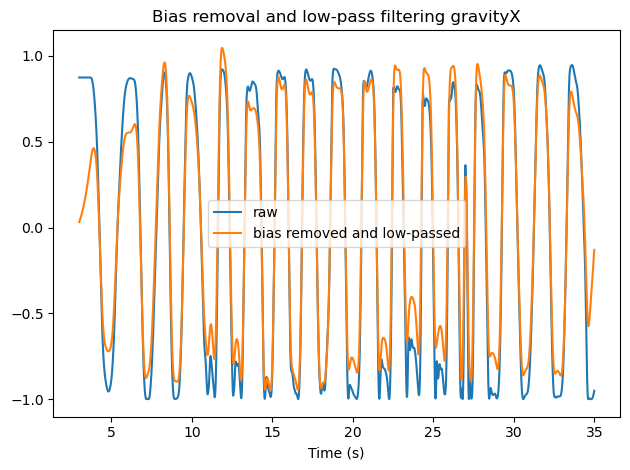

In [124]:
t = df_seg['seconds_elapsed'].values
sig = df_seg['gravityX'].values

plt.figure()
plt.plot(t, sig, label='raw')
plt.plot(t, sig_filtered, label='bias removed and low-passed')
plt.legend()
plt.title("Bias removal and low-pass filtering gravityX")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [122]:
print("Raw mean:", np.mean(sig))
print("HP mean:", np.mean(sig_hp))

Raw mean: -0.037435305997697184
HP mean: 0.0017062677988891758


# segment by peaks

In [ ]:
'''
Function returns list of start and end indices of each repetition in the signal.
and also number of reps detected.
'''
def segment_rep(): 
    